<a href="https://colab.research.google.com/github/farnaz-Nawaz/AI_LFC_Controller/blob/main/LFC_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating dataset...
Generated X shape (395600, 20) Y shape (395600,)
Training ANN...
Epoch 1/20
1391/1391 - 7s - 5ms/step - loss: 0.0051 - mae: 0.0127 - val_loss: 3.4263e-05 - val_mae: 0.0035
Epoch 2/20
1391/1391 - 5s - 3ms/step - loss: 3.0081e-05 - mae: 0.0031 - val_loss: 3.1860e-05 - val_mae: 0.0031
Epoch 3/20
1391/1391 - 6s - 4ms/step - loss: 2.8278e-05 - mae: 0.0032 - val_loss: 3.3259e-05 - val_mae: 0.0029
Epoch 4/20
1391/1391 - 5s - 3ms/step - loss: 2.7450e-05 - mae: 0.0033 - val_loss: 1.1626e-05 - val_mae: 0.0019
Epoch 5/20
1391/1391 - 5s - 3ms/step - loss: 3.1938e-05 - mae: 0.0034 - val_loss: 3.2233e-05 - val_mae: 0.0038
Epoch 6/20
1391/1391 - 6s - 4ms/step - loss: 2.2944e-05 - mae: 0.0029 - val_loss: 4.0176e-05 - val_mae: 0.0051
Epoch 7/20
1391/1391 - 5s - 4ms/step - loss: 1.9853e-05 - mae: 0.0029 - val_loss: 1.4853e-05 - val_mae: 0.0025


Evaluating controllers on test scenario...


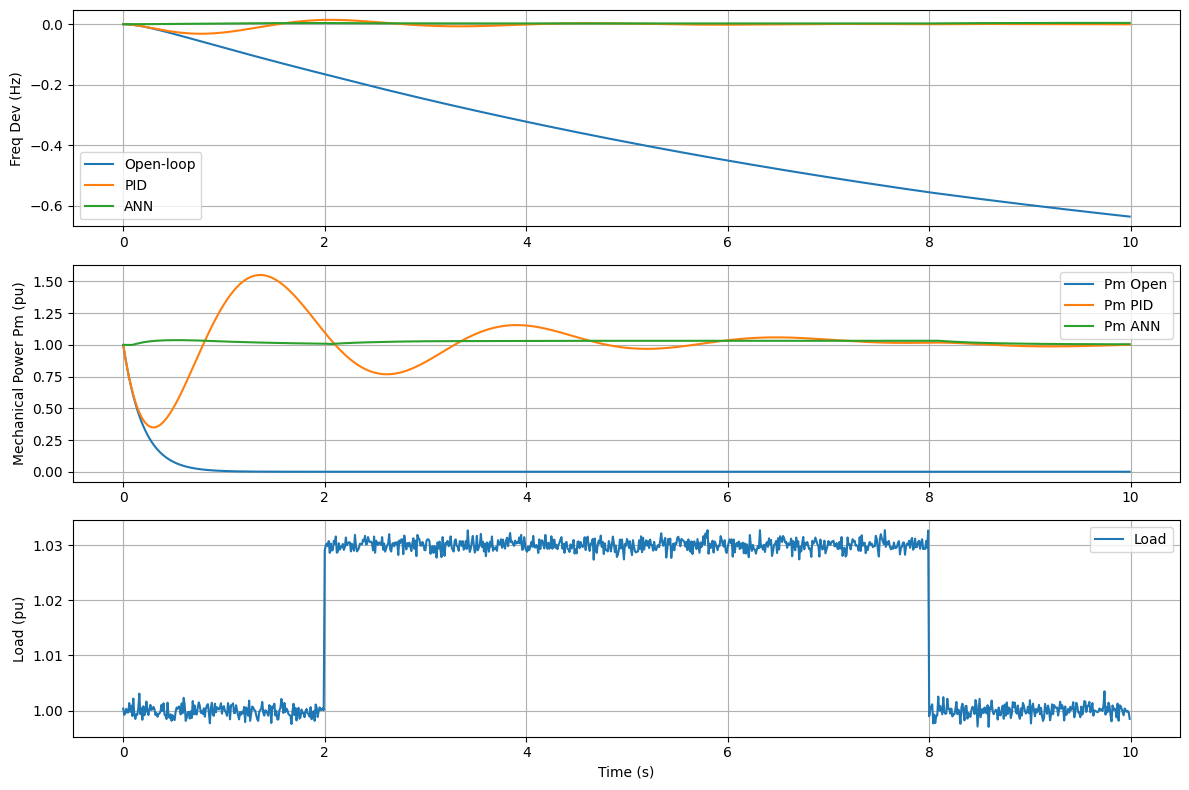

RMS frequency deviations: {'open_rms': np.float64(0.4088901933365542), 'pid_rms': np.float64(0.009196215253385591), 'ann_rms': np.float64(0.0029388126132101964)}
Done. Files saved: ann_lfc_model.h5, scaler_X_params.json, scaler_Y_params.json


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import json

np.random.seed(42)
tf_random_seed = 42
tf.random.set_seed(tf_random_seed)

# ---------------------------
# 1) Simple single-area LFC simulator
# ---------------------------
# We'll simulate a simplified first-order governor+ turbine + generator frequency response.
# Continuous-time model (simplified): 2H/omega_s * df/dt = Pm - Pe - D * f
# We'll discretize with Euler method. The governor will apply control-u which adjusts mechanical power Pm.

class SingleAreaLFC:
    def __init__(self, H=5.0, D=1.0, Tg=0.2, R=2.4, dt=0.01):
        # H: inertia constant
        # D: damping coefficient (power change per unit freq)
        # Tg: governor time constant (simple first-order)
        # R: speed regulation
        self.H = H
        self.D = D
        self.Tg = Tg
        self.R = R
        self.dt = dt
        self.omega_s = 2*np.pi*50  # not used directly, keep for completeness

    def simulate(self, load_profile, controller_fn=None, Pm0=1.0):
        # load_profile: array of electrical load (Pe) in pu over time
        n = len(load_profile)
        f = np.zeros(n)      # frequency deviation (Hz) from nominal
        Pm = np.zeros(n)     # mechanical power
        Pm[0] = Pm0
        governor_state = Pm0
        for t in range(1, n):
            # controller determines control action (delta Pm) based on current state
            if controller_fn is None:
                u = 0.0
            else:
                # controller expected to accept (t, f_history, Pm_history, load_history) and return delta Pm
                u = controller_fn(t, f[:t], Pm[:t], load_profile[:t])

            # simple governor dynamics: Pm_dot = ( - (Pm - u) ) / Tg  -> relax towards u
            governor_state += self.dt * (-(governor_state - u))/max(self.Tg, 1e-6)
            Pm[t] = governor_state

            Pe = load_profile[t]
            df_dt = (Pm[t] - Pe - self.D * f[t-1])/(2*self.H)
            f[t] = f[t-1] + self.dt * df_dt

        return f, Pm

# ---------------------------
# 2) Controllers: PID baseline and open-loop
# ---------------------------
class PIDController:
    def __init__(self, Kp=1.0, Ki=0.1, Kd=0.01, dt=0.01, u_min=-2.0, u_max=2.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.u_min = u_min
        self.u_max = u_max
        self.integral = 0.0
        self.prev_error = 0.0

    def reset(self):
        self.integral = 0.0
        self.prev_error = 0.0

    def __call__(self, t, f_hist, Pm_hist, load_hist):
        # control to reduce frequency deviation -> error = -f (we want f->0)
        if len(f_hist) == 0:
            error = -0.0
        else:
            error = -f_hist[-1]
        self.integral += error * self.dt
        derivative = (error - self.prev_error)/self.dt if len(f_hist)>1 else 0.0
        u = self.Kp*error + self.Ki*self.integral + self.Kd*derivative
        self.prev_error = error
        return float(np.clip(u, self.u_min, self.u_max))

# ---------------------------
# 3) Generate dataset (many random load profiles)
# ---------------------------
def generate_random_load_profiles(n_profiles=2000, T=10.0, dt=0.01):
    steps = int(T/dt)
    sim = SingleAreaLFC(dt=dt)
    X = []  # input features
    Y = []  # target next-step frequency deviation

    for i in range(n_profiles):
        # baseline load is 1.0 pu. add random steps and noise
        load = np.ones(steps) * 1.0
        # random number of step disturbances
        n_steps = np.random.randint(1, 6)
        for _ in range(n_steps):
            start = np.random.randint(0, steps-50)
            magnitude = np.random.uniform(-0.05, 0.05)  # +-5% load change
            duration = np.random.randint(5, 200)
            load[start:start+duration] += magnitude

        # small random fluctuations
        load += np.random.normal(0, 1e-3, size=steps)

        # simulate open-loop (no controller) to get frequency trace
        f, Pm = sim.simulate(load_profile=load, controller_fn=None, Pm0=1.0)

        # build supervised examples: use last window of load and freq to predict next f
        window = 10  # number of previous timesteps used as features
        for t in range(window, steps-1):
            feat = np.concatenate([f[t-window:t], load[t-window:t]])
            target = f[t+1]
            X.append(feat)
            Y.append(target)

    X = np.array(X)
    Y = np.array(Y)
    print('Generated X shape', X.shape, 'Y shape', Y.shape)
    return X, Y

# ---------------------------
# 4) Build and train ANN (Dense)
# ---------------------------
def build_ann(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    return model

# ---------------------------
# 5) Train pipeline
# ---------------------------

def train_ann_model(X, Y, epochs=10, batch_size=512, val_split=0.1):
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    Xs = scaler_X.fit_transform(X)
    Ys = scaler_Y.fit_transform(Y.reshape(-1,1)).ravel()

    X_train, X_val, Y_train, Y_val = train_test_split(Xs, Ys, test_size=val_split, random_state=42)

    model = build_ann(X.shape[1])
    cb = [callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, callbacks=cb, verbose=2)

    return model, scaler_X, scaler_Y, history

# ---------------------------
# 6) Use ANN as controller (closed-loop)
# ---------------------------
# We'll construct a wrapper controller that uses the ANN to predict the next frequency and decide Pm target.
# Strategy: ANN predicts delta-f_next given recent window -> choose u to bring predicted f_next closer to 0.

class ANNController:
    def __init__(self, model, scaler_X, scaler_Y, window=10, dt=0.01, u_min=-2.0, u_max=2.0):
        self.model = model
        self.scaler_X = scaler_X
        self.scaler_Y = scaler_Y
        self.window = window
        self.dt = dt
        self.u_min = u_min
        self.u_max = u_max

    def __call__(self, t, f_hist, Pm_hist, load_hist):
        if len(f_hist) < self.window:
            return 1.0  # nominal
        # build feature
        feat = np.concatenate([f_hist[-self.window:], load_hist[-self.window:]])
        feat_s = self.scaler_X.transform(feat.reshape(1,-1))
        pred_scaled = self.model.predict(feat_s, verbose=0)
        pred = self.scaler_Y.inverse_transform(pred_scaled.reshape(-1,1)).ravel()[0]
        # desired correction: want next freq to be zero -> error_next = -pred
        # find simple proportional action
        K = 10.0
        correction = K * (-pred)
        # compute u as nominal mechanical power plus correction; keep bounds
        u = 1.0 + correction
        u = float(np.clip(u, self.u_min + 1.0, self.u_max + 1.0))
        return u

# ---------------------------
# 7) Evaluation and plots
# ---------------------------

def evaluate_controllers(load_profile, sim_dt=0.01, ann_controller=None, pid_controller=None):
    sim = SingleAreaLFC(dt=sim_dt)
    # open-loop
    f_open, Pm_open = sim.simulate(load_profile, controller_fn=None, Pm0=1.0)

    # PID
    pid_controller.reset()
    f_pid, Pm_pid = sim.simulate(load_profile, controller_fn=pid_controller, Pm0=1.0)

    # ANN
    f_ann, Pm_ann = sim.simulate(load_profile, controller_fn=ann_controller, Pm0=1.0)

    # metrics: RMS deviation
    def rms(x):
        return np.sqrt(np.mean(x**2))

    metrics = {
        'open_rms': rms(f_open),
        'pid_rms': rms(f_pid),
        'ann_rms': rms(f_ann)
    }

    # plotting
    t = np.arange(len(load_profile))*sim_dt
    plt.figure(figsize=(12,8))
    plt.subplot(3,1,1)
    plt.plot(t, f_open, label='Open-loop')
    plt.plot(t, f_pid, label='PID')
    plt.plot(t, f_ann, label='ANN')
    plt.ylabel('Freq Dev (Hz)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3,1,2)
    plt.plot(t, Pm_open, label='Pm Open')
    plt.plot(t, Pm_pid, label='Pm PID')
    plt.plot(t, Pm_ann, label='Pm ANN')
    plt.ylabel('Mechanical Power Pm (pu)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3,1,3)
    plt.plot(t, load_profile, label='Load')
    plt.ylabel('Load (pu)')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return metrics

# ---------------------------
# 8) Putting it all together: generate data, train, evaluate on a test scenario
# ---------------------------
if __name__ == '__main__':
    print('Generating dataset...')
    X, Y = generate_random_load_profiles(n_profiles=400, T=10.0, dt=0.01)

    print('Training ANN...')
    model, scaler_X, scaler_Y, history = train_ann_model(X, Y, epochs=20, batch_size=256, val_split=0.1)

    # save model and scalers
    model.save('ann_lfc_model.h5')
    with open('scaler_X_params.json', 'w') as f:
        json.dump({'mean': scaler_X.mean_.tolist(), 'scale': scaler_X.scale_.tolist()}, f)
    with open('scaler_Y_params.json', 'w') as f:
        json.dump({'mean': scaler_Y.mean_.tolist(), 'scale': scaler_Y.scale_.tolist()}, f)

    # create controllers
    ann_ctrl = ANNController(model=model, scaler_X=scaler_X, scaler_Y=scaler_Y, window=10, dt=0.01)
    pid_ctrl = PIDController(Kp=20.0, Ki=50.0, Kd=0.0, dt=0.01, u_min=-2.0, u_max=2.0)

    # build a test load profile with a large step
    steps = int(10.0/0.01)
    load = np.ones(steps) * 1.0
    load[200:800] += 0.03  # 3% step up
    load += np.random.normal(0, 1e-3, size=steps)

    print('Evaluating controllers on test scenario...')
    metrics = evaluate_controllers(load_profile=load, sim_dt=0.01, ann_controller=ann_ctrl, pid_controller=pid_ctrl)
    print('RMS frequency deviations:', metrics)

    print('Done. Files saved: ann_lfc_model.h5, scaler_X_params.json, scaler_Y_params.json')

# ---------------------------
# README & requirements (suggested)
# ---------------------------
# requirements.txt (suggested):
# tensorflow>=2.10
# numpy
# matplotlib
# scikit-learn

# README (short):
# 1. Open this script in Google Colab.
# 2. Install requirements: !pip install -q tensorflow numpy matplotlib scikit-learn
# 3. Run cells; training may take several minutes depending on epochs & Colab runtime.
# 4. Observe plots and RMS metrics. Compare ANN controller vs PID and open-loop.

# Tips to improve for hackathon:
# - Use LSTM instead of Dense to capture temporal dynamics (option 3 in earlier message)
# - Use more realistic multi-area models and include tie-line dynamics
# - Use reinforcement learning to directly optimize control reward (minimize freq dev and control effort)
# - Make a Streamlit/Flask demo to interactively change disturbance and show results